Layout for Project (Template)

- Background: Discuss population models (birth rate, death rate, overall population) and how we can use stochastic models to reflect real world data

- Maths: Introduce important math components
    - OU Process: Derivation, Mean\Variance, Other Components
    - Maximum Likelihood Estimator: How it is applied to an OU Process --> Introduce scipy optimiser
    - Dickey Fuller Test: How they are used to identify mean reverting time series + the mathematical derivation behind it
    - Population Model: Show results and conclusions by applying it to the population model in paper
- Also maybe introduce Langevin model or Trading Data Example???

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import statsmodels.tsa.stattools as ts
from scipy.stats import norm
from scipy.optimize import minimize
import re

In [44]:
data = pd.read_csv("EcuadorPopulation.csv")
#data = pd.read_csv("japanfm3539.csv")
#data = pd.read_csv("Ecuador_M_3539.csv")
#data = pd.read_csv("finlandfm3539.csv")
#data = pd.read_csv("finland.csv")
#data = pd.read_csv("Ecuadorfm3539.csv")

population = data.loc[0]
birthrate = data.loc[1]
deathrate = data.loc[2]

start_year = 1960
end_year = 2019
years = [str(year) + ' [YR' + str(year) + ']' for year in range(start_year, end_year)]


def extract_data(df):
    df = df[years]  # Extract the specific row and filter columns
    df = df.reset_index()
    df.columns = ['years', 'population']
    df = df["population"].tolist()
    return df

birthrate = extract_data(birthrate)
deathrate = extract_data(deathrate)
population = extract_data(population)

'''birthrate = [i/1000 for i in birthrate]
deathrate = [i/1000 for i in deathrate]'''

#print(birthrate)
#print(deathrate)
#print(population)
#print(type(birthrate))

'birthrate = [i/1000 for i in birthrate]\ndeathrate = [i/1000 for i in deathrate]'

In [45]:
def augmented_dickey_fuller(goog):
    # Output the results of the Augmented Dickey-Fuller test for Google
    # with a lag order value of 1
    adf = ts.adfuller(goog, 1)
    print(adf)

print("DF Test for Death Rate:")
augmented_dickey_fuller(deathrate)
print("\n")
print("DF Test for Birth Rate:")
augmented_dickey_fuller(birthrate)

DF Test for Death Rate:
(-2.151519835918039, 0.22430878849600383, 1, 57, {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}, -191.3085942520181)


DF Test for Birth Rate:
(-1.0935793038150476, 0.7176256006163686, 1, 57, {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}, -92.23868276750926)


In [46]:
'''data = pd.read_csv("wv.csv")
print(data)
start_year = 1925
end_year = 2022
years = [str(year) for year in range(start_year, end_year)]

def extract_data(df):
    df_birthrate = df["BirthRate"].tolist()
    df_deathrate = df["DeathRate"].tolist()
    df_population = df["Population"].tolist()
    return df_birthrate, df_deathrate, df_population

birthrate, deathrate, population = extract_data(data)

'''

'data = pd.read_csv("wv.csv")\nprint(data)\nstart_year = 1925\nend_year = 2022\nyears = [str(year) for year in range(start_year, end_year)]\n\ndef extract_data(df):\n    df_birthrate = df["BirthRate"].tolist()\n    df_deathrate = df["DeathRate"].tolist()\n    df_population = df["Population"].tolist()\n    return df_birthrate, df_deathrate, df_population\n\nbirthrate, deathrate, population = extract_data(data)\n\n'

In [47]:
def get_mean_birth_rate(df):
    sum = 0
    for i in range(len(df)):
        sum += df[i]
    sum = sum/len(df)
    return sum

mean = get_mean_birth_rate(birthrate)
print(mean)

def get_mean_death_rate(df):
    sum = 0
    for i in range(len(df)):
        sum += df[i]
    sum = sum/len(df)
    return sum

mean_birth_rate = get_mean_birth_rate(birthrate)
print("Mean Birth Rate from " + str(start_year) + " to " + str(end_year) + ": " + str(round(mean_birth_rate, 5)))

mean_death_rate = get_mean_death_rate(deathrate)
print("Mean Death Rate from " + str(start_year) + " to " + str(end_year) + ": " + str(round(mean_death_rate, 5)))

31.050050847457626
Mean Birth Rate from 1960 to 2019: 31.05005
Mean Death Rate from 1960 to 2019: 7.75932


In [48]:
def OU(x1, x2, dt, theta, mu, sigma):
    sigma0 = sigma**2 * (1 - np.exp(-2*mu*dt)) / (2 * mu)
    sigma0 = np.sqrt( sigma0 )
    
    prefactor = 1 / np.sqrt(2 * np.pi * sigma0**2)
    
    f =  prefactor * np.exp( -(x2 - x1 * np.exp(-mu*dt) - \
                    theta * (1-np.exp(-mu*dt)) )**2 / (2 * sigma0**2) )
    
    return f

#  Calculate the negative of the log likelihood
def log_likelihood_OU(p, X, dt):
    
    theta = p[0]
    mu = p[1]
    sigma = p[2]
    
    N = len(X)
    
    f = np.zeros( (N-1, ) )
    
    for i in range( 1, N ):
        x2 = X[i]
        x1 = X[i-1]
        
        f[i-1] = OU(x1, x2, dt, theta, mu, sigma)
    
    ind = np.where(f == 0)
    ind = ind[0]
    if ind.size > 0:
        f[ind] = 10**-8
        
    f = np.log(f)
    f = np.sum(f)
        
    return -f

#  mu and sigma must be greater than zero.  We use these contraint functions with minimze
def constraint1( p ):
    return p[1]

def constraint2( p ):
    return p[2]


#  Add constraint function to a dictionary
cons = ( {'type':'ineq', 'fun': constraint1},
         {'type':'ineq', 'fun': constraint2} )

#  Initial guess for our parameters
p0 = [1, 1, 1]

#  Call minimize

output_deathrate = minimize(log_likelihood_OU, p0, args = (deathrate, 1/len(deathrate)), constraints=cons)
print(output_deathrate)
[mu_optimised_death, gamma_optimised_death, sigma_optimised_death] = output_deathrate["x"]
print(mu_optimised_death)

#  Add constraint function to a dictionary
cons = ( {'type':'ineq', 'fun': constraint1},
         {'type':'ineq', 'fun': constraint2} )

#  Initial guess for our parameters
p0 = [1, 1, 1]

output_birthrate = minimize(log_likelihood_OU, p0, args = (birthrate, 1/len(birthrate)), constraints=cons)
print(output_birthrate)
[mu_optimised_birth, gamma_optimised_birth, sigma_optimised_birth] = output_birthrate["x"]
print(mu_optimised_birth)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -56.719407158411684
       x: [ 3.140e+00  2.325e+00  7.128e-01]
     nit: 11
     jac: [ 2.901e-03 -1.154e-02 -1.862e-03]
    nfev: 52
    njev: 11
3.1403840478400546
 message: Iteration limit reached
 success: False
  status: 9
     fun: -22.458332157207582
       x: [-1.634e+03  1.602e-02  1.262e+00]
     nit: 100
     jac: [ 8.156e-04 -8.067e+01 -1.293e-02]
    nfev: 439
    njev: 100
-1634.2417125542145


59


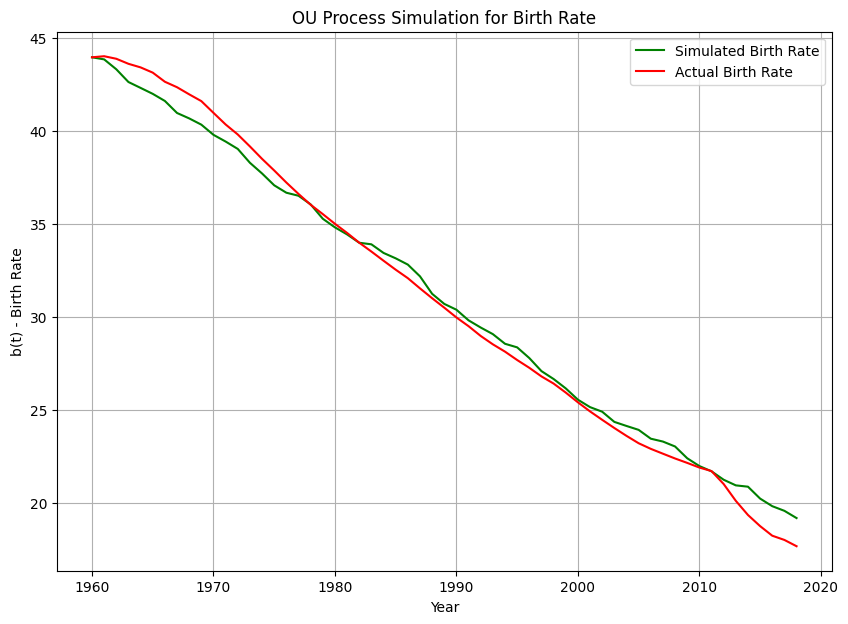

In [49]:
def plot_results_birthrate(gamma_b, sigma_b):
    
    #gamma_b = 0.7
    #b_e = mean_birth_rate
    
    b_e = mu_optimised_birth

    X_0 = birthrate[0]
    T = len(birthrate)
    dt = 1/T
    #N = int(T/dt)
    N = len(birthrate)
    print(N)
    X = np.zeros(N)
    X[0] = X_0


    X_actual = birthrate
    X_actual = np.array(X_actual)

    #print(X_actual.shape)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    #print(X_actual)
    for t in range(1,N):
        dW = np.sqrt(dt) * np.random.normal(0,1)
        X[t] = X[t-1] + gamma_b * (b_e - X[t-1]) * dt + sigma_b * dW
        
    plt.figure(figsize=(10,7))
    plt.plot(year_labels, X, color="g", label = "Simulated Birth Rate")
    plt.plot(year_labels, X_actual, color="r", label = "Actual Birth Rate")
    plt.title("OU Process Simulation for Birth Rate")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("b(t) - Birth Rate")
    
    return X, X_actual, year_labels

X, X_actual, year_labels = plot_results_birthrate(gamma_optimised_birth, sigma_optimised_birth)


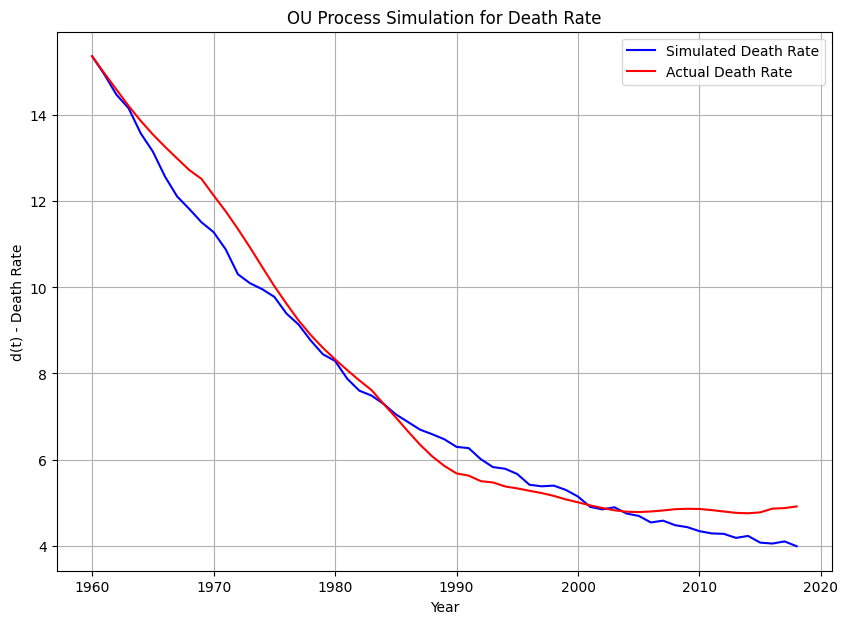

In [50]:
def plot_results_deathrate(gamma_d,sigma_d):

    d_e = mu_optimised_death
    gamma_d = gamma_optimised_death
    sigma_d = sigma_optimised_death
    
    X_0 = deathrate[0]
    T = len(deathrate)
    dt = 1/T
    N = len(deathrate)
    X = np.zeros(N)
    X[0] = X_0

    X_actual = deathrate
    X_actual = np.array(X_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    for t in range(1,N):
        dW = np.sqrt(dt) * np.random.normal(0,1)
        X[t] = X[t-1] + gamma_d * (d_e - X[t-1]) * dt + sigma_d * dW
    
    plt.figure(figsize=(10,7))
    plt.plot(year_labels, X, color="b", label = "Simulated Death Rate")
    plt.plot(year_labels, X_actual, color="r", label = "Actual Death Rate")
    plt.title("OU Process Simulation for Death Rate")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("d(t) - Death Rate")
    plt.show()
    
    
    return X, X_actual, year_labels

X, X_actual, year_labels = plot_results_deathrate(gamma_optimised_death, sigma_optimised_death)


def get_results_deathrate(gamma_d,sigma_d):
    
    d_e = mu_optimised_death
    gamma_d = gamma_optimised_death
    sigma_d = sigma_optimised_death
    
    X_0 = deathrate[0]
    T = len(deathrate)
    dt = 1/T
    N = len(deathrate)
    X = np.zeros(N)
    X[0] = X_0

    X_actual = deathrate
    X_actual = np.array(X_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    for t in range(1,N):
        dW = np.sqrt(dt) * np.random.normal(0,1)
        X[t] = X[t-1] + gamma_d * (d_e - X[t-1]) * dt + sigma_d * dW    
    
    return X, X_actual, year_labels


def get_results_birthrate(gamma_b, sigma_b):

    b_e = mu_optimised_birth
    gamma_b = gamma_optimised_birth
    sigma_b = sigma_optimised_birth

    X_0 = birthrate[0]
    T = len(birthrate)
    dt = 1/T
    #N = int(T/dt)
    N = len(birthrate)
    X = np.zeros(N)
    X[0] = X_0


    X_actual = birthrate
    X_actual = np.array(X_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    for t in range(1,N):
        dW = np.sqrt(dt) * np.random.normal(0,1)
        X[t] = X[t-1] + gamma_b * (b_e - X[t-1]) * dt + sigma_b * dW
    
    return X, X_actual, year_labels


In [51]:
def sim_d(gamma_d, sigma_d):
    simulations = 100
    plt.figure(figsize=(10, 7)) 
    for i in range(simulations):
        X, X_actual, year_labels = get_results_deathrate(gamma_d, sigma_d)
        plt.plot(year_labels, X, alpha=0.25)
    
    plt.plot(year_labels, X_actual, color="g", label="Actual Death Rate")

    plt.title("Simulation for Death Rate")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("D(t) - Death Rate")
    plt.show()
    
    
# Define your sliders
gamma_d_slider = widgets.FloatSlider(min=gamma_optimised_death-10, max=gamma_optimised_death+10, step=0.1, value=gamma_optimised_death, description="Rate of Reversion")
sigma_d_slider = widgets.FloatSlider(min=sigma_optimised_death - 1, max=sigma_optimised_death + 1, step=0.01, value=sigma_optimised_death, description="Volatility")

# Create a grid layout for the sliders (2x3 layout)
grid_layout = widgets.GridBox(
    children=[gamma_d_slider, sigma_d_slider],
    layout=Layout(grid_template_columns="repeat(2, 300px)", grid_template_rows="repeat(1, auto)", grid_gap="10px")
)



# Display the interactive widgets and buttons in a grid layout
ui = widgets.VBox([grid_layout])
out = widgets.interactive_output(sim_d, {
    'gamma_d': gamma_d_slider, 
    'sigma_d': sigma_d_slider
})

display(ui, out)

Output()

In [ ]:
def sim_b(gamma_b, sigma_b):
    simulations = 100
    plt.figure(figsize=(10, 7))
    for i in range(simulations):
        X, X_actual, year_labels = get_results_birthrate(gamma_b, sigma_b)
        plt.plot(year_labels, X, alpha=0.25)
    plt.plot(year_labels, X_actual, color="g")

    plt.title("Simulation for Birth Rate")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("B(t) - Birth Rate")
    plt.show()
    

# Define your sliders
gamma_b_slider = widgets.FloatSlider(min=gamma_optimised_birth-10, max=gamma_optimised_birth +10, step=0.1, value=gamma_optimised_birth, description="Rate of Reversion")
sigma_b_slider = widgets.FloatSlider(min = sigma_optimised_birth - 1, max = sigma_optimised_birth+1, step=0.01, value=sigma_optimised_birth, description="Volatility")

# Create a grid layout for the sliders (2x3 layout)
grid_layout = widgets.GridBox(
    children=[gamma_b_slider, sigma_b_slider],
    layout=Layout(grid_template_columns="repeat(2, 300px)", grid_template_rows="repeat(1, auto)", grid_gap="10px")
)



# Display the interactive widgets and buttons in a grid layout
ui = widgets.VBox([grid_layout])
out = widgets.interactive_output(sim_b, {
    'gamma_b': gamma_b_slider, 
    'sigma_b': sigma_b_slider
})

display(ui, out)

Output()

In [53]:
def get_population_model(factor):
    
    
    b_e = mu_optimised_birth*factor
    sigma_b = sigma_optimised_birth*factor
    gamma_b = gamma_optimised_birth
    
    d_e = mu_optimised_death*factor
    gamma_d = gamma_optimised_death
    sigma_d = sigma_optimised_death*factor

    B_0 = birthrate[0]*factor
    D_0 = deathrate[0]*factor
    Y_0 = population[0]
    T = len(deathrate)
    #dt = 1/T
    #N = int(T/dt)
    dt = 1/T
    N = len(deathrate)
    
    Y = np.zeros(N)
    Y[0] = Y_0
    
    B = np.zeros(N)
    B[0] = B_0
    
    D = np.zeros(N)
    D[0] = D_0
    
    Y_actual = population
    Y_actual = np.array(Y_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]

    for t in range(1,N):
        dW1 = np.sqrt(dt) * np.random.normal(0,1) # Population Weiner Process
        dW2 = np.sqrt(dt) * np.random.normal(0,1) # Birth Rate Weiner Process
        dW3 = np.sqrt(dt) * np.random.normal(0,1) # Death Rate Weiner Process
        
        B[t] = max(B[t-1] + gamma_b * (b_e - B[t-1]) * dt + sigma_b * dW2,0)
        D[t] = max(D[t-1] + gamma_d * (d_e - D[t-1]) * dt + sigma_d * dW3,0)
    
        Y[t] = Y[t-1] + (B[t-1] - D[t-1]) * Y[t-1] * (dt) + np.sqrt(Y[t-1]*(B[t-1] + D[t-1])) * dW1
        
    return Y
    
Y = get_population_model(1/1000)

C:\Users\JKelly\AppData\Local\Temp\ipykernel_25176\1498026250.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


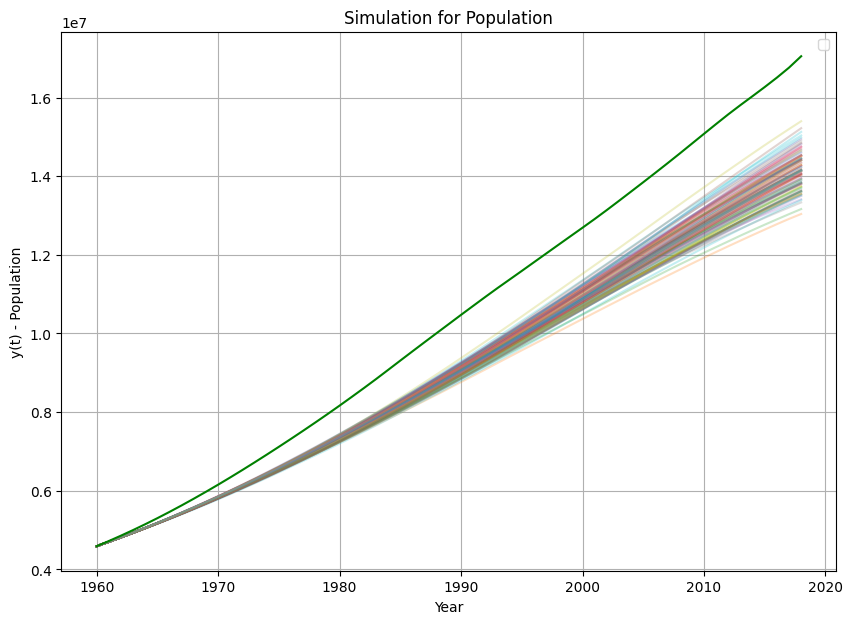

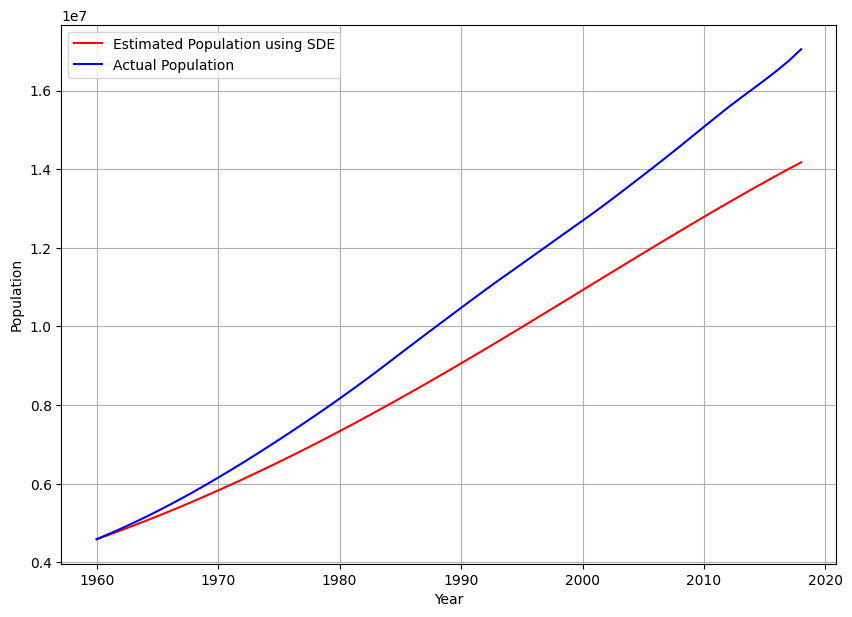

In [54]:
def main(factor):

    simulations = 100
    plt.figure(figsize=(10,7))
    Y_actual = population
    Y_actual = np.array(Y_actual)

    x_vals = list(range(len(years)))
    year_labels = [start_year + i for i in x_vals]
    Y_vault = []
    for i in range(simulations):
        Y = get_population_model(factor)
        Y_vault.append(Y)
        plt.plot(year_labels, Y, alpha=0.25)
    plt.plot(year_labels, Y_actual, color="g")

    plt.title("Simulation for Population")
    plt.legend()
    plt.grid(True)
    plt.xlabel("Year")
    plt.ylabel("y(t) - Population")
    plt.show()

    return Y_vault

Y_vault = main(0.05)

mean_pop_per_year = []
for i in range(len(Y_vault[0])):
    
    year_slice = []
    
    for j in range(len(Y_vault)):
        year_slice.append(Y_vault[j][i])
        
    mean_pop_per_year.append(np.mean(year_slice))
    
#print(mean_pop_per_year)

plt.figure(figsize=(10,7))
plt.plot(year_labels, mean_pop_per_year, color='r', label="Estimated Population using SDE")
plt.plot(year_labels, population, color="b", label="Actual Population")
plt.legend()
plt.grid(True)
plt.xlabel("Year")
plt.ylabel("Population")
plt.show()


In [55]:
# Define your sliders
factor_slider = widgets.FloatSlider(min=0.001, max=1, step=0.001, value=0.1, description="Factor")

# Create a grid layout for the sliders (2x3 layout)
grid_layout = widgets.GridBox(
    children=[factor_slider],
    layout=Layout(grid_template_columns="repeat(1, 300px)", grid_template_rows="repeat(1, auto)", grid_gap="10px")
)



# Display the interactive widgets and buttons in a grid layout
ui = widgets.VBox([grid_layout])
out = widgets.interactive_output(main, {
    'factor': factor_slider
})

display(ui, out)

Output()

In [56]:
population = '4,429,634	4,461,005	4,491,443	4,523,309	4,548,543	4,563,732	4,580,869	4,605,744	4,626,469	4,623,785	4,606,307	4,612,124	4,639,657	4,666,081	4,690,574	4,711,440	4,725,664	4,738,902	4,752,528	4,764,690	4,779,535	4,799,964	4,826,933	4,855,787	4,881,803	4,902,206	4,918,154	4,932,123	4,946,481	4,964,371	4,986,431	5,013,740	5,041,992	5,066,447	5,088,333	5,107,790	5,124,573	5,139,835	5,153,498	5,165,474	5,176,209	5,188,008	5,200,598	5,213,014	5,228,172	5,246,096	5,266,268	5,288,720	5,313,399	5,338,871	5,363,352	5,388,272	5,413,971	5,438,972	5,461,512	5,479,531	5,495,303	5,508,214	5,515,525	5,521,606'
birth_rate = '18.50	18.40	18.10	18.20	17.70	17.10	17	16.80	15.90	14.60	14	13.20	12.70	12.20	13.30	13.90	14.10	13.90	13.50	13.30	13.20	13.20	13.70	13.80	13.30	12.80	12.30	12.10	12.80	12.80	13.10	13	13.20	12.80	12.80	12.30	11.80	11.50	11.10	11.10	11	10.80	10.70	10.90	11	11	11.20	11.10	11.20	11.30	11.40	11.10	11	10.70	10.50	10.10	9.60	9.10	8.60	8.30'
death_rate = '9	9.10	9.50	9.30	9.30	9.70	9.50	9.50	9.70	9.90	9.60	9.90	9.50	9.30	9.50	9.30	9.50	9.30	9.20	9.20	9.30	9.30	9	9.30	9.20	9.80	9.60	9.70	9.90	9.90	10	9.80	9.90	10.10	9.40	9.60	9.60	9.60	9.60	9.60	9.50	9.40	9.50	9.40	9.10	9.10	9.10	9.30	9.20	9.30	9.50	9.40	9.60	9.50	9.60	9.60	9.80	9.80	9.90	9.80'

population = population.replace(',', '')
population = population.split()
birth_rate = birth_rate.split()
death_rate = death_rate.split()


population = [int(i) for i in population]
birth_rate = [float(i) for i in birth_rate]
death_rate = [float(i) for i in death_rate]

print(population)
print(birth_rate)
print(death_rate)

[4429634, 4461005, 4491443, 4523309, 4548543, 4563732, 4580869, 4605744, 4626469, 4623785, 4606307, 4612124, 4639657, 4666081, 4690574, 4711440, 4725664, 4738902, 4752528, 4764690, 4779535, 4799964, 4826933, 4855787, 4881803, 4902206, 4918154, 4932123, 4946481, 4964371, 4986431, 5013740, 5041992, 5066447, 5088333, 5107790, 5124573, 5139835, 5153498, 5165474, 5176209, 5188008, 5200598, 5213014, 5228172, 5246096, 5266268, 5288720, 5313399, 5338871, 5363352, 5388272, 5413971, 5438972, 5461512, 5479531, 5495303, 5508214, 5515525, 5521606]
[18.5, 18.4, 18.1, 18.2, 17.7, 17.1, 17.0, 16.8, 15.9, 14.6, 14.0, 13.2, 12.7, 12.2, 13.3, 13.9, 14.1, 13.9, 13.5, 13.3, 13.2, 13.2, 13.7, 13.8, 13.3, 12.8, 12.3, 12.1, 12.8, 12.8, 13.1, 13.0, 13.2, 12.8, 12.8, 12.3, 11.8, 11.5, 11.1, 11.1, 11.0, 10.8, 10.7, 10.9, 11.0, 11.0, 11.2, 11.1, 11.2, 11.3, 11.4, 11.1, 11.0, 10.7, 10.5, 10.1, 9.6, 9.1, 8.6, 8.3]
[9.0, 9.1, 9.5, 9.3, 9.3, 9.7, 9.5, 9.5, 9.7, 9.9, 9.6, 9.9, 9.5, 9.3, 9.5, 9.3, 9.5, 9.3, 9.2, 9.2, 9